# Libraries

In [ ]:
import nltk
from nltk.corpus import brown, stopwords
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from nltk.tokenize import word_tokenize
import time
import seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

## Downloading data

In [ ]:
nltk.download("brown")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

## Exploring the corpus

In [ ]:
brown_words =  brown.tagged_words(tagset="universal")
brown_sentences = brown.tagged_sents(tagset="universal")

In [ ]:
brown_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [ ]:
len(brown_words)

1161192

In [ ]:
brown_sentences[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [ ]:
len(brown_sentences)

57340

Now, let us check whether *brown_words* and *brown_sentences* have the same (word,tag) pairs.

In [ ]:
brown_sent2words = []
for sent in  brown_sentences:
  for word_tag in sent:
    brown_sent2words.append(word_tag)

In [ ]:
print(len(brown_words) - len(brown_sent2words))

0


The number of (word,tag) pairs are the same in both

In [ ]:
i = 0
while(i != len(brown_words)):
  if(brown_words[i] != brown_sent2words[i]):
    print(brown_words[i], brown_sent2words[i])
  i += 1

This means that the (word,tag) pairs in the two are the same.

### Tags in the tagset

In [ ]:
unique_tags = []

for sent in brown_sentences:
  for (word, tag) in sent:
    if(tag not in unique_tags):
      unique_tags.append(tag)

In [ ]:
print(unique_tags)

['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X']


In [ ]:
print(len(unique_tags))

12


## Data Preprocessing

In [ ]:
max_len_sentence = 0
for sent in brown_sentences:
  max_len_sentence = max(max_len_sentence, len(sent))

In [ ]:
print(max_len_sentence)

180


In [ ]:
n = 0
for sent in brown_sentences:
  if(len(sent) >= 100):
    n += 1

In [ ]:
print(n)

40


The max. length of any sentence in the data is 180, and the number of sentences with length >= 100 is just 40.

So let us choose the standardizing length to be 100.

In [ ]:
STD_LEN = 100

In [ ]:
words = []
tags = []

for sent in brown_sentences:
  words.append([])
  tags.append([])
  for (word, tag) in sent:
    words[-1].append(word.lower())
    tags[-1].append(tag)

In [ ]:
print(words[:4])

[['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['the', 'september-october', 'term', 'jury', 'had', 'been', 'charged', 'by', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'mayor-nominate', 'ivan', 'allen', 'jr.', '.'], ['``', 'only', 'a', 'relative', 'handful', 'of', 'such', 'rep

Splitting data into train:test ratio of 90:10

In [ ]:
train_words = words[:len(words)*9//10]
train_tags = tags[:len(tags)*9//10]

test_words = words[len(words)*9//10:]
test_tags = tags[len(words)*9//10:]

### Giving ids to the data

In [ ]:
word2id = {}

for i in range(len(words)):
  for word in words[i]:
    if(word not in word2id):
      word2id[word] = len(word2id)

tag2id = {}

for i in range(len(tags)):
  for tag in tags[i]:
    if(tag not in tag2id):
      tag2id[tag] = len(tag2id)

In [ ]:
print(len(word2id))

49815


In [ ]:
print(len(tag2id))

12


In [ ]:
# Setup GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_x = []
train_y = []

for (w, t) in zip(train_words, train_tags):
  x = [word2id[word] for word in w]
  y = [tag2id[tag] for tag in t]

  x = torch.from_numpy(np.array(x)).to(device)
  y = torch.from_numpy(np.array(y)).to(device)

  train_x.append(x)
  train_y.append(y)

In [ ]:
test_x = []
test_y = []

for (w, t) in zip(test_words, test_tags):
  x = [word2id[word] for word in w]
  y = [tag2id[tag] for tag in t]

  x = torch.from_numpy(np.array(x)).to(device)
  y = torch.from_numpy(np.array(y)).to(device)

  test_x.append(x)
  test_y.append(y)

5-fold cross validation has to be done splitting the training data into 5 almost equal parts

In [ ]:
train_valid_x = []
train_valid_y = []
m = len(train_x)

for i in range(5):
  part_x = train_x[i*m//5:(i+1)*m//5]
  part_y = train_y[i*m//5:(i+1)*m//5]

  train_valid_x.append(part_x)
  train_valid_y.append(part_y)

# Model

In [ ]:
class POStagger(nn.Module):

  def __init__(self, vocab_size, target_size, embedding_dim, hidden_state_dim):
    super(POStagger, self).__init__()

    self.vocab_size = vocab_size
    self.target_size = target_size
    self.embedding_dim = embedding_dim
    self.hidden_state_dim = hidden_state_dim

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.lstm = nn.LSTM(embedding_dim, hidden_state_dim)

    self.output = nn.Linear(hidden_state_dim, target_size)

    self.hidden_state = self.hidden_state_initialize()

  def hidden_state_initialize(self):
    return (torch.zeros(1, 1, self.hidden_state_dim).to(device), torch.zeros(1, 1, self.hidden_state_dim).to(device))

  def forward(self, input):
    embeddings = self.embeddings(input)

    lstm_output, self.hidden_state = self.lstm(embeddings.view(len(input), 1, -1), self.hidden_state)

    output = self.output(lstm_output.view(len(input), -1))

    probs = F.log_softmax(output, dim=1)

    return probs

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_STATE_DIM = 128

model = POStagger(len(word2id), len(tag2id), EMBEDDING_DIM, HIDDEN_STATE_DIM).to(device)

criterion = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.3)
optimizer = optim.Adam(model.parameters())

# Training

In [ ]:
def weight_initialize(model):
  for _, parameters in model.named_parameters():
    nn.init.uniform_(parameters.data, -1, 1)

model.apply(weight_initialize)

POStagger(
  (embeddings): Embedding(49815, 128)
  (lstm): LSTM(128, 128)
  (output): Linear(in_features=128, out_features=12, bias=True)
)

In [ ]:
# def train(model, X, y, optimizer, criterion):

#   model.train()

#   model.hidden_state_initialize()

#   # total_loss = 0

#   # for (X, y) in zip(X_loader, y_loader):
#     # X = torch.reshape(X, X.size()[1:])
#     # y = torch.reshape(y, y.size()[1:])

#   model.zero_grad()

#   probs = model(X)

#   loss = criterion(probs, y)
#   loss.backward()
#   # total_loss += loss.item()

#   optimizer.step()

#   return loss.item()

In [ ]:
# def evaluate(model, X, y, criterion):

#   model.eval()

#   # total_loss = 0

#   # for (X, y) in zip(X_loader, y_loader):
#     # X = torch.reshape(X, X.size()[1:])
#     # y = torch.reshape(y, y.size()[1:])

#   probs = model(X)

#   loss = criterion(probs, y)
#   # total_loss += loss.item()

#   return loss.item()

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  tic = time.time()

  epoch_training_loss = 0.0
  epoch_validation_loss = 0.0

  r = np.random.randint(5)
  for i in range(5):
    if(i != r):
      # for (xs, ys) in zip(train_valid_x[i], train_valid_y[i]):
      #   train_loss = train(model, xs, ys, optimizer, criterion)
      model.train()

      for (xs, ys) in zip(train_valid_x[i], train_valid_y[i]):
        print(xs)
        model.zero_grad()

        model.hidden_state = model.hidden_state_initialize()

        probs = model(xs)

        loss = criterion(probs, ys)
        epoch_training_loss += loss.item()
        loss.backward()

        optimizer.step()

  # valid_loss = evaluate(model, xs, ys, criterion)
  model.eval()
  for (xs, ys) in zip(train_valid_x[r], train_valid_y[r]):
    with torch.no_grad():
      model.hidden_state = model.hidden_state_initialize()

      probs = model(xs)

      loss = criterion(probs, ys)
      epoch_validation_loss += loss.item()

  toc = time.time()

  epoch_time = toc - tic
  epoch_min = epoch_time // 60
  epoch_sec = epoch_time % 60

  torch.save(model.state_dict(), "model%d" % (epoch+1))

  print(f"Epoch : {epoch+1} -- Training loss : {epoch_training_loss/len(train_words)},\t Validation loss : {epoch_validation_loss/len(train_words)},\t Time : {epoch_min}m {epoch_sec}s")

  # torch.save(model.state_dict(), "model%d" % (epoch+1))
  # print(f"Epoch : {epoch+1} -- training loss : {epoch_training_loss/len(train_words)}, validation loss : {epoch_validation_loss/len(train_words)}" )

Streaming output truncated to the last 5000 lines.
tensor([   15,  2995,  8933,   127, 37495,  5717,   118,   104,     0,  2541,
          456, 14366,     0, 23858,    18,    24], device='cuda:0')
tensor([20996,  2250, 29069,  2797,   168,     0, 27394,    32, 46835, 46836,
           24], device='cuda:0')
tensor([   15,  2939,  4433,  5788, 46008,   440,     0, 19890,    32,  3594,
           18,    32,   397,  2681, 18059,    32,  1885,    50,     0, 13673,
         3259,  2044,  4116,  2946,    24], device='cuda:0')
tensor([   15,   697,   934,  2939,   191,   127,   440,   104,   418,    50,
        34422,    18,    24], device='cuda:0')
tensor([ 456,    9,    0, 2924,    9,  335, 2462,   32,  397, 1212,  698,  335,
        9766, 8254, 3274,   56, 4741,   24], device='cuda:0')
tensor([  482,  3594,    34,    67,  2507,    56,  2167,    32, 20996,  5114,
          335,   714,  5016,   859,   335,  6073, 46837,  3849,    24],
       device='cuda:0')
tensor([  648,    16,  9198,   375

# Loading trained model

In [ ]:
model = POStagger(len(word2id), len(tag2id), EMBEDDING_DIM, HIDDEN_STATE_DIM).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/IITB/Sem6/CS772/A2/model20_encoder"))

<All keys matched successfully>

# Testing

In [ ]:
testing_loss = 0.0
precision = {}
recall = {}
f1 = {}
f0_5 = {}
f2 = {}

pred_tag = np.zeros((len(tag2id),len(tag2id)), np.int32)

model.eval()
for (xs, ys) in zip(test_x, test_y):
  with torch.no_grad():
    model.hidden_state = model.hidden_state_initialize()

    probs = model(xs)

    loss = criterion(probs, ys)
    testing_loss += loss.item()

    # j = 0
    # for p in probs:
    #   pred = 0
    #   for i in range(1,len(tag2id)):
    #     if(p[i] > p[i-1]):
    #       pred = i
    #   pred_tag[pred,ys[j]] += 1
    #   j += 1

    for i in range(len(xs)):
      pred = torch.argmax(probs[i])
      pred = int(pred)
      pred_tag[pred, ys[i]] += 1


for i in range(len(tag2id)):
  row_sum = 0
  column_sum = 0
  for j in range(len(tag2id)):
    # print(pred_tag[i,j])
    row_sum += pred_tag[i,j]
  for j in range(len(tag2id)):
    column_sum += pred_tag[j,i]

  if(row_sum != 0):
    precision[unique_tags[i]] = pred_tag[i,i]*1.0/row_sum
  if(column_sum != 0):
    recall[unique_tags[i]] = pred_tag[i,i]*1.0/column_sum
  f1[unique_tags[i]] = 2*precision[unique_tags[i]]*recall[unique_tags[i]]/(precision[unique_tags[i]]+recall[unique_tags[i]])
  f0_5[unique_tags[i]] = 1.25*precision[unique_tags[i]]*recall[unique_tags[i]]/(0.25*precision[unique_tags[i]]+recall[unique_tags[i]])
  f2[unique_tags[i]] = 5*precision[unique_tags[i]]*recall[unique_tags[i]]/(4*precision[unique_tags[i]]+recall[unique_tags[i]])

print(pred_tag)

print(f"Test loss : {testing_loss/len(test_x)}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-score : {f1}")
print(f"F0.5-score : {f0_5}")
print(f"F2-score : {f2}")


[[ 9914     9     0     2   170     0    29     7     1   163     0     0]
 [    2 16326   491   374     5     0    43     0    41     2    17    73]
 [    1   352  4617    76    15     0   172     0    29     0     3     8]
 [    1   647   123 16377     8     0    38     0    38     1     1    19]
 [   39    32     4    21  8871     0   216     2   430    20     0     1]
 [    0     1     1     1     0 15504     0     0     0     0     0     1]
 [    5   143   240    46   153     0  4781     3    55     2     3     7]
 [    2     0     0     0     8     0     4  3313     0     0     0     0]
 [    0    32     7    10   361     0    70     0  2847     0     0     4]
 [  149     6     1     1    39     0     0     0     2  7165     0     0]
 [    0   113     5     8     0     0     4     0     2     0   463     1]
 [    0    31     3     1     0     1     0     1     1     0     0    10]]
Test loss : 0.21329085923997224
Precision : {'DET': 0.9629917435648373, 'NOUN': 0.9396799815816738,

<Axes: >

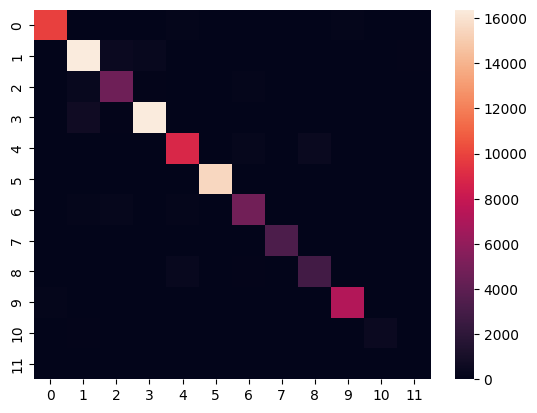

In [ ]:
# Heatmap

seaborn.heatmap(pred_tag)

In [ ]:
# Macro scores

macro_precision = 0.0
NA_precisions = 0
for i in precision:
  if(precision[i] == "NA"):
    NA_precisions += 1
  else:
    macro_precision += precision[i]
macro_precision /= (len(tag2id) - NA_precisions)

macro_recall = 0.0
NA_recalls = 0
for i in recall:
  if(recall[i] == "NA"):
    NA_recalls += 1
  else:
    macro_recall += recall[i]
macro_recall /= (len(tag2id) - NA_recalls)

macro_f1 = 2*macro_precision*macro_recall/(macro_precision+macro_recall)
macro_f0_5 = 1.25*macro_precision*macro_recall/(0.25*macro_precision+macro_recall)
macro_f2 = 5*macro_precision*macro_recall/(4*macro_precision+macro_recall)

print(f"Macro precision: {macro_precision}")
print(f"Macro recall: {macro_recall}")
print(f"Macro f1 score: {macro_f1}")
print(f"Macro f0.5 score: {macro_f0_5}")
print(f"Macro f2 score: {macro_f2}")

Macro precision: 0.8613170369842336
Macro recall: 0.86279402341325
Macro f1 score: 0.8620548975570976
Macro f0.5 score: 0.8616120295873914
Macro f2 score: 0.862498221028574


In [ ]:
# Micro scores

den = 0.0
for i in range(len(tag2id)):
  for j in range(len(tag2id)):
    den += pred_tag[i][j]

micro_precision = 0.0
for i in range(len(tag2id)):
  micro_precision += pred_tag[i,i]
micro_precision /= den

micro_recall = 0.0
for i in range(len(tag2id)):
  micro_recall += pred_tag[i,i]
micro_recall /= den

micro_f1 = 2*micro_precision*micro_recall/(micro_precision+micro_recall)
micro_f0_5 = 1.25*micro_precision*micro_recall/(0.25*micro_precision+micro_recall)
micro_f2 = 5*micro_precision*micro_recall/(4*micro_precision+micro_recall)

print(f"Micro precision: {micro_precision}")
print(f"Micro recall: {micro_recall}")
print(f"Micro f1 score: {micro_f1}")
print(f"Micro f0.5 score: {micro_f0_5}")
print(f"Micro f2 score: {micro_f2}")

Micro precision: 0.944950860208294
Micro recall: 0.944950860208294
Micro f1 score: 0.944950860208294
Micro f0.5 score: 0.944950860208294
Micro f2 score: 0.944950860208294


# Inference

In [ ]:
# # id = word2id["work"]

# for i in range(len(words)):
#   for j in range(len(words[i])):
#     if(words[i][j] == "that"):
#       print(tags[i][j])

In [ ]:
# Training example
input = ' '.join(words[0])

In [ ]:
def infer(input):
  # Use for inference
  input_tokens = word_tokenize(input.lower())

  # Use for training example
  # input_tokens = input.lower().strip().split()

  input_nums = []

  for i in range(len(input_tokens)):
    if(input_tokens[i] not in word2id):
      input_nums.append(11)
    else:
      input_nums.append(word2id[input_tokens[i]])

  input_tensor = torch.from_numpy(np.array(input_nums)).to(device)

  model.eval()
  with torch.no_grad():
    model.hidden_state = model.hidden_state_initialize()

    probs = model(input_tensor)

    # for p in probs:
    #   pred = 0
    #   for i in range(1,len(tag2id)):
    #     if(p[i] > p[i-1]):
    #       pred = i
    #   print(unique_tags[pred])

    for i in range(len(input_tensor)):
      pred = torch.argmax(probs[i])
      pred = int(pred)
      print(unique_tags[pred])

In [ ]:
# Inference
input = "Can you open this can?"

In [ ]:
infer(input)

VERB
PRON
VERB
DET
VERB
.
